In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import scipy as sp
import numpy as np
from matplotlib.lines import Line2D
import collections
import random
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import kernighan_lin_bisection
import community as community_louvain
from networkx.algorithms.community import label_propagation_communities
from itertools import combinations
from collections import defaultdict
import pandas as pd
import ast
#from sklearn.metrics import adjusted_rand_score #needed if we want to calculate ARI in task 9.
import time


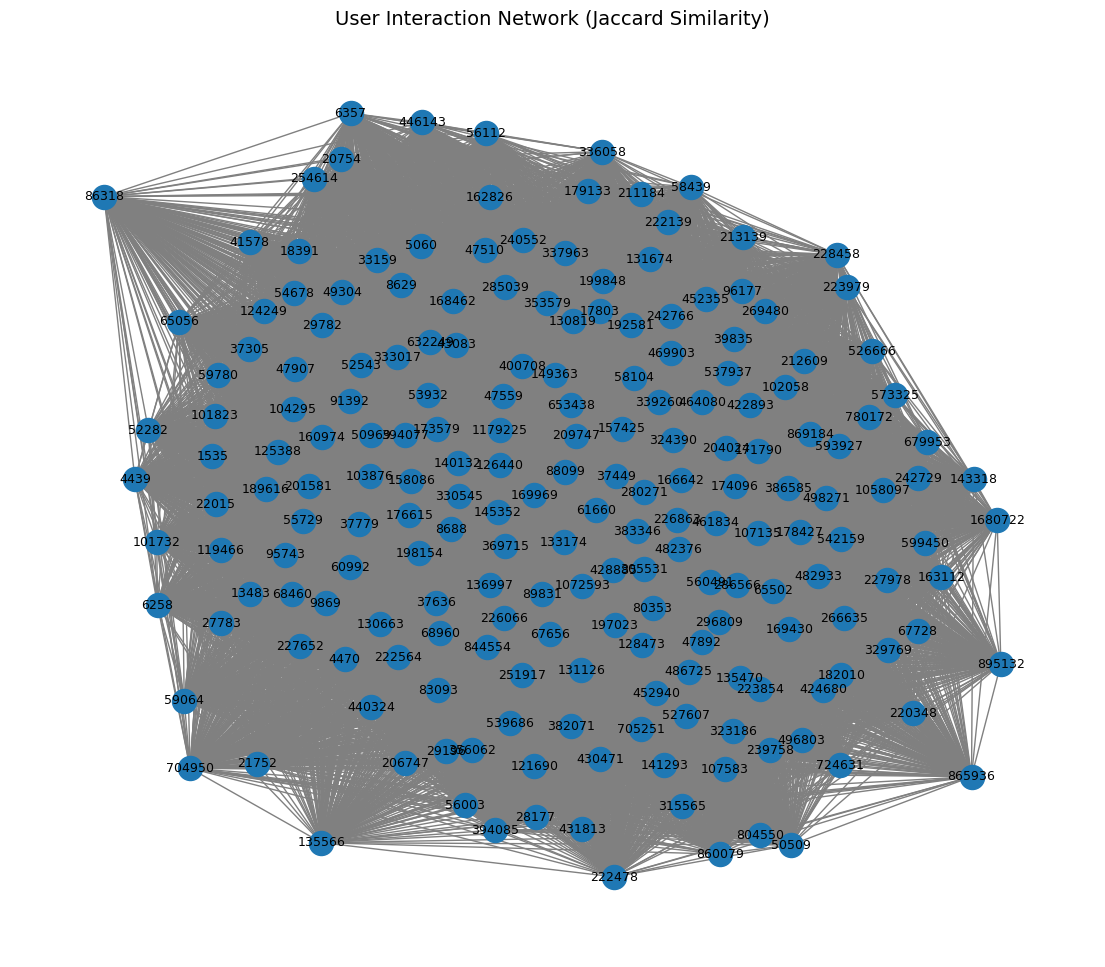

Execution time: 10.73 seconds


In [2]:
#1 Generate a user interaction network
import time
start_time = time.time()

interactions = pd.read_csv("RAW_interactions.csv")
interactions = interactions[['user_id', 'recipe_id', 'rating']]

# Top 200 most active users
user_counts = interactions['user_id'].value_counts()
selected_users = user_counts.head(200).index.tolist()

filtered_interactions = interactions[interactions['user_id'].isin(selected_users)]


user_recipe_map = defaultdict(set)
for _, row in filtered_interactions.iterrows():
    user_recipe_map[row['user_id']].add(row['recipe_id'])

# Initialize the graph
G = nx.Graph()
G.add_nodes_from(selected_users)

# Create edges using Jaccard similarity based on rated recipes
for user1, user2 in combinations(selected_users, 2):
    set1 = user_recipe_map[user1]
    set2 = user_recipe_map[user2]
    
    intersection = set1 & set2
    union = set1 | set2

    if not union:
        continue 
    
    similarity = len(intersection) / len(union)

    if similarity > 0:
        G.add_edge(user1, user2, weight=similarity)

# Draw the graph
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("User Interaction Network (Jaccard Similarity)", fontsize=14)
plt.axis('off')
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

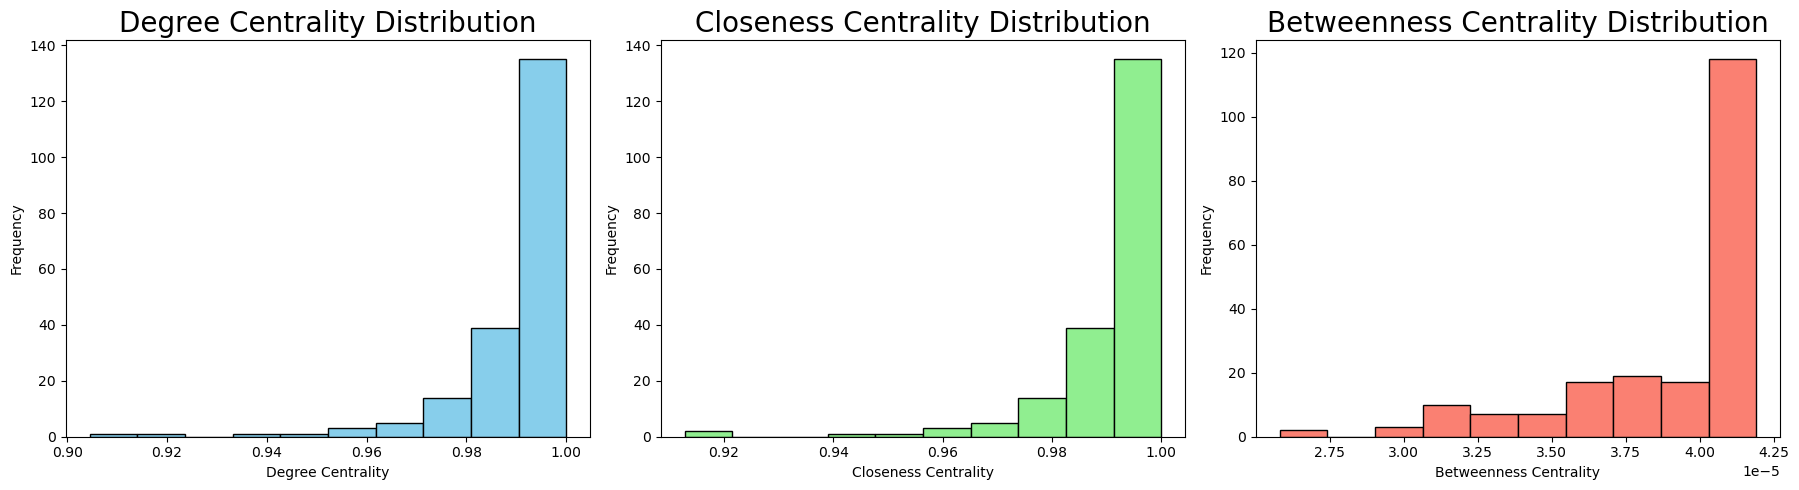

In [3]:
#2 Visualize and plot the degree distribution
#calculate centralities
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)


degree_vals = list(degree_centrality.values())
closeness_vals = list(closeness_centrality.values())
betweenness_vals = list(betweenness_centrality.values())

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})
ax[0].hist(degree_vals, bins=10, color='skyblue', edgecolor='black')
ax[0].set_title('Degree Centrality Distribution')
ax[0].set_xlabel('Degree Centrality')
ax[0].set_ylabel('Frequency')

ax[1].hist(closeness_vals, bins=10, color='lightgreen', edgecolor='black')
ax[1].set_title('Closeness Centrality Distribution')
ax[1].set_xlabel('Closeness Centrality')
ax[1].set_ylabel('Frequency')

ax[2].hist(betweenness_vals, bins=10, color='salmon', edgecolor='black')
ax[2].set_title('Betweenness Centrality Distribution')
ax[2].set_xlabel('Betweenness Centrality')
ax[2].set_ylabel('Frequency')
plt.savefig("Centrality.png", dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()


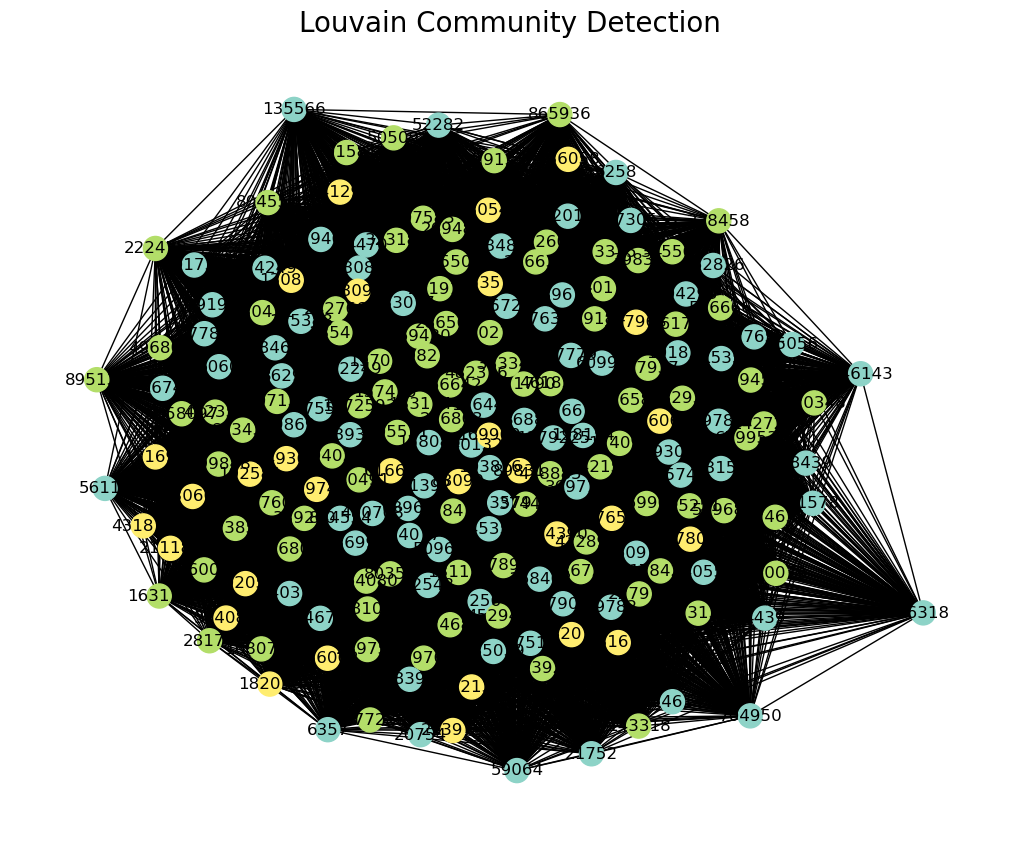

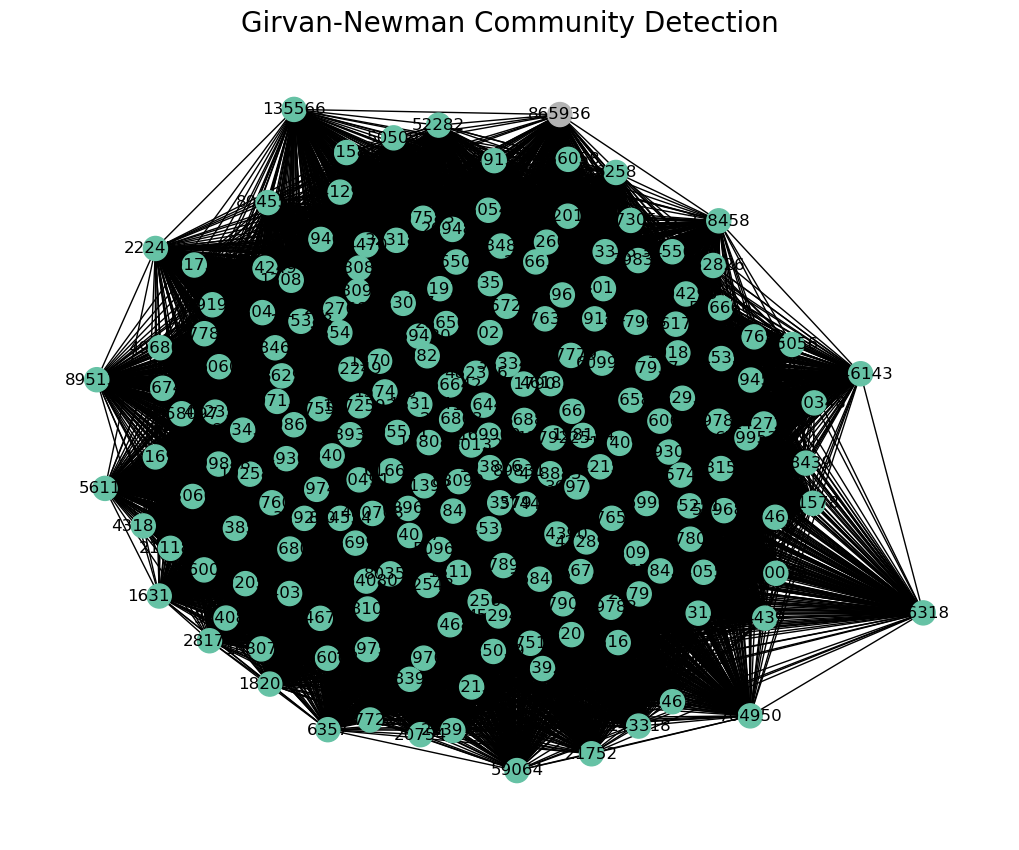


Community Summary (Louvain):
   Community  Nodes  Edges  Diameter  Avg Path Length  Avg Degree
0          1     90   4003         2         1.000499   88.955556
1          2     30    435         1         1.000000   29.000000
2          0     80   3154         2         1.001899   78.850000

Community Summary (Girvan-Newman):
     Community  Nodes  Edges  Diameter  Avg Path Length  Avg Degree
0  Community 1    199  19565       2.0         1.006903  196.633166
1  Community 2      1      0       NaN              NaN    0.000000
Execution time: 101.71 seconds


In [4]:
#3 Detect communities within the user interaction network
import time

start_time = time.time()
# Louvain Community Detection
louvain_partition = community_louvain.best_partition(G)
louvain_colors = [louvain_partition[node] for node in G.nodes()]

pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=louvain_colors, with_labels=True, node_size=300, cmap=plt.cm.Set3)
plt.title("Louvain Community Detection")
plt.axis("off")
plt.show()

# Girvan-Newman Community Detection
gn_generator = girvan_newman(G)
top_level_communities = next(gn_generator)
gn_communities = [list(c) for c in top_level_communities]

gn_node_color_map = {}
for i, community in enumerate(gn_communities):
    for node in community:
        gn_node_color_map[node] = i
gn_colors = [gn_node_color_map[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=gn_colors, with_labels=True, node_size=300, cmap=plt.cm.Set2)
plt.title("Girvan-Newman Community Detection")
plt.axis("off")
plt.show()

# Community Statistics

def compute_community_stats_lo(graph, partition):
    reverse_partition = defaultdict(list)
    for node, comm_id in partition.items():
        reverse_partition[comm_id].append(node)

    stats = []
    for comm_id, nodes in reverse_partition.items():
        subgraph = graph.subgraph(nodes)
        num_nodes = subgraph.number_of_nodes()
        num_edges = subgraph.number_of_edges()
        if num_nodes > 0:
            avg_degree = np.mean([d for _, d in subgraph.degree()])
        else:
            avg_degree = 0

        if nx.is_connected(subgraph) and num_nodes > 1:
            diameter = nx.diameter(subgraph)
        else:
            diameter = float('nan')
            
        if nx.is_connected(subgraph) and num_nodes > 1:
            avg_path = nx.average_shortest_path_length(subgraph)
        else:
            avg_path = float('nan')
        stats.append({
            'Community': comm_id,
            'Nodes': num_nodes,
            'Edges': num_edges,
            'Diameter': diameter,
            'Avg Path Length': avg_path,
            'Avg Degree': avg_degree
        })
    return pd.DataFrame(stats)

def compute_community_stats_gn(graph, communities):
    stats = []
    for i, nodes in enumerate(communities):
        subgraph = graph.subgraph(nodes)
        num_nodes = subgraph.number_of_nodes()
        num_edges = subgraph.number_of_edges()
        if num_nodes > 0:
            avg_degree = np.mean([d for _, d in subgraph.degree()])
        else:
            avg_degree = 0

        if nx.is_connected(subgraph) and num_nodes > 1:
            diameter = nx.diameter(subgraph)
        else:
            diameter = float('nan')
            
        if nx.is_connected(subgraph) and num_nodes > 1:
            avg_path = nx.average_shortest_path_length(subgraph)
        else:
            avg_path = float('nan')
        stats.append({
            'Community': f'Community {i+1}',
            'Nodes': num_nodes,
            'Edges': num_edges,
            'Diameter': diameter,
            'Avg Path Length': avg_path,
            'Avg Degree': avg_degree
        })
    return pd.DataFrame(stats)

#print the result
community_stats_lo = compute_community_stats_lo(G, louvain_partition)
print("\nCommunity Summary (Louvain):")
print(community_stats_lo)

community_stats_gn = compute_community_stats_gn(G, gn_communities)
print("\nCommunity Summary (Girvan-Newman):")
print(community_stats_gn)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Assortativity Coefficient (by avg rating): -0.0046


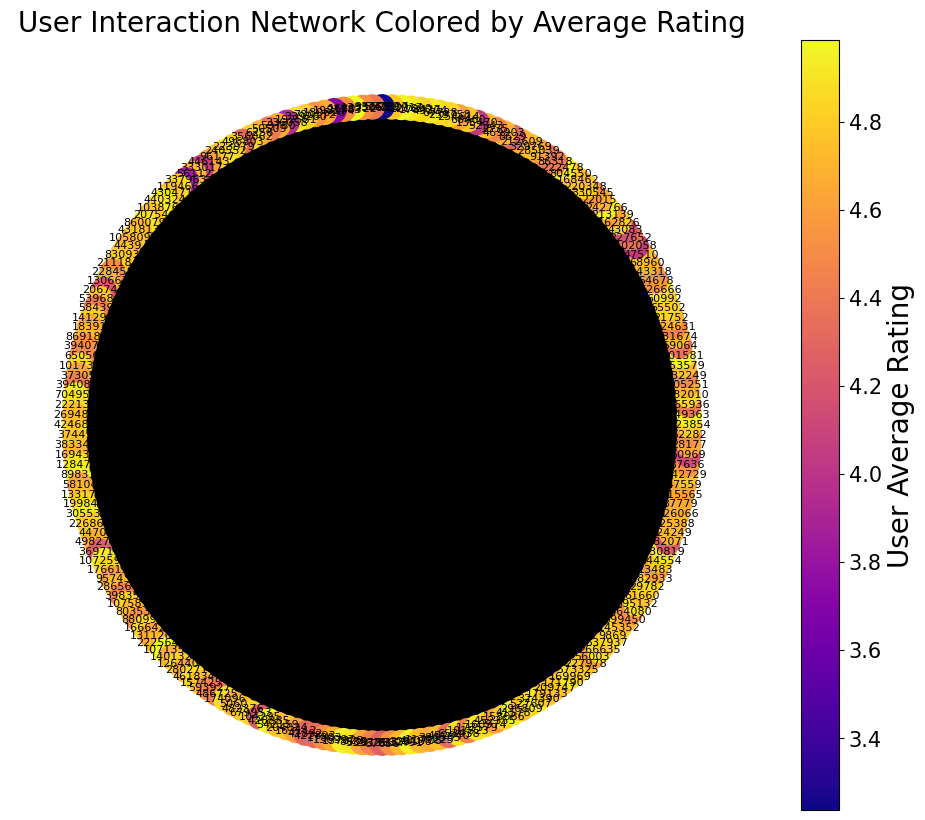

In [5]:
#4 Analyze the assortativity of the network

#Calculate average rating per user
user_avg_rating = interactions.groupby('user_id')['rating'].mean().to_dict()

#Compute assortativity coefficient
nx.set_node_attributes(G, user_avg_rating, "avg_rating")
assortativity = nx.numeric_assortativity_coefficient(G, "avg_rating")
print(f"Assortativity Coefficient (by avg rating): {assortativity:.4f}")
rating_vals = [user_avg_rating.get(n, 0) for n in G.nodes()]
pos = nx.shell_layout(G)

plt.figure(figsize=(12, 10))
nodes = nx.draw_networkx_nodes(G, pos, node_color=rating_vals, cmap=plt.cm.plasma, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.colorbar(nodes, label="User Average Rating")
plt.title("User Interaction Network Colored by Average Rating")
plt.axis("off")
plt.show()


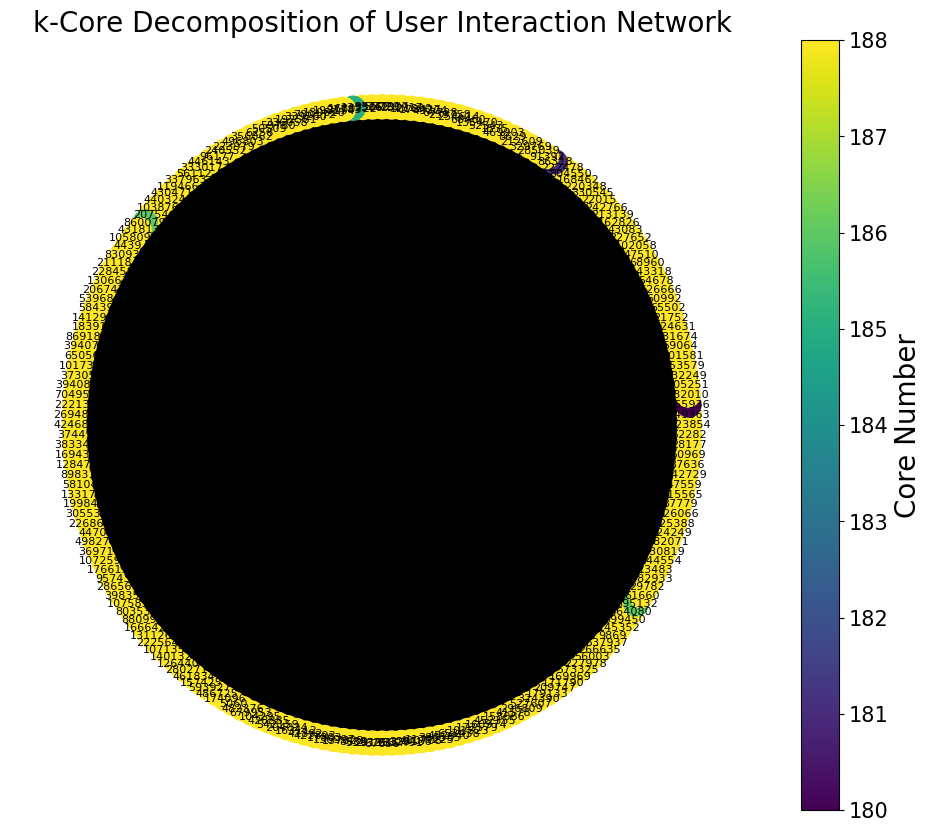

   k-core  Nodes  Edges   Density  Avg Degree  Avg Clustering
0     180    200  19745  0.992211  197.450000        0.992500
1     181    199  19565  0.993097  196.633166        0.993305
2     185    198  19384  0.993898  195.797980        0.994043
3     186    197  19199  0.994458  194.913706        0.994569
4     188    195  18827  0.995348  193.097436        0.995409


In [6]:
#5

#Compute core number for each node
core_nums = nx.core_number(G)


nx.set_node_attributes(G, core_nums, "core")

plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)
node_colors = [core_nums[node] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.viridis, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.colorbar(nodes, label="Core Number")
plt.title("k-Core Decomposition of User Interaction Network")
plt.axis("off")
plt.show()

#Analyze node counts per core level
core_counts = pd.Series(list(core_nums.values())).value_counts().sort_index()


core_subgraphs = {}
core_stats = []

# Analyze each k-core
for k in sorted(set(core_nums.values())):
    subG = nx.k_core(G, k)
    degrees = [d for _, d in subG.degree()]
    clustering_coeffs = list(nx.clustering(subG).values())
    density = nx.density(subG)
    avg_degree = np.mean(degrees) if degrees else 0
    avg_clustering = np.mean(clustering_coeffs) if clustering_coeffs else 0

    core_stats.append({
        'k-core': k,
        'Nodes': subG.number_of_nodes(),
        'Edges': subG.number_of_edges(),
        'Density': density,
        'Avg Degree': avg_degree,
        'Avg Clustering': avg_clustering
    })


core_stats_df = pd.DataFrame(core_stats)
print(core_stats_df)


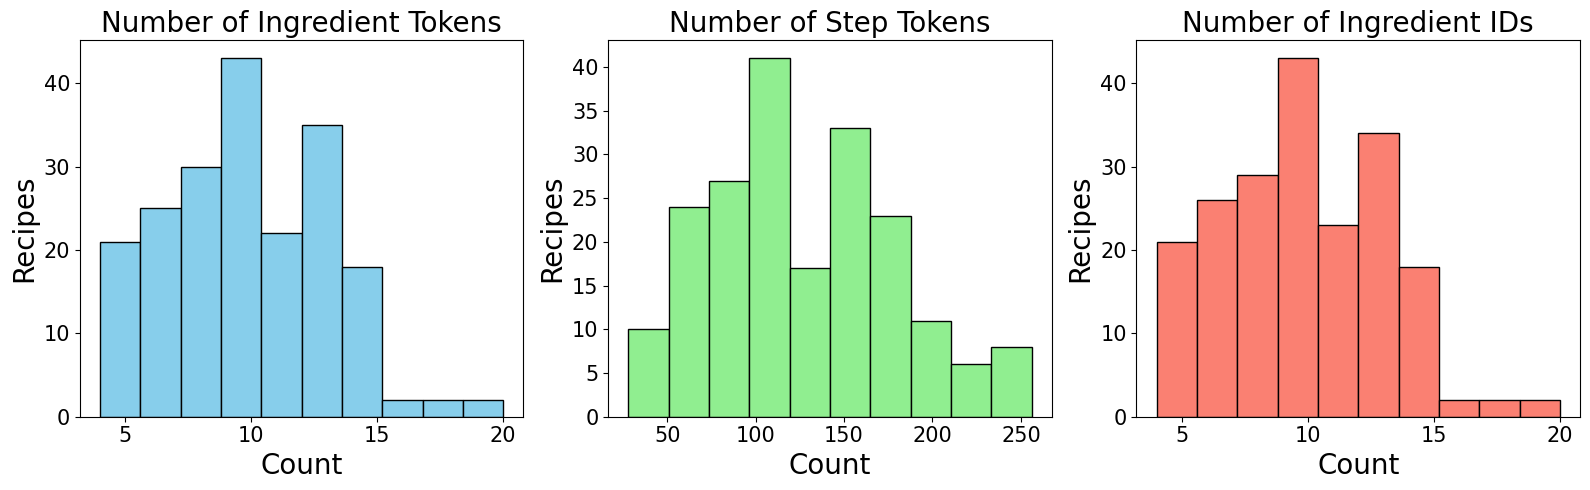

In [7]:
#6

#use the fist 200 as an example
df = pd.read_csv("PP_recipes.csv", nrows=200)


df['ingredient_tokens'] = df['ingredient_tokens'].apply(ast.literal_eval)
df['steps_tokens'] = df['steps_tokens'].apply(ast.literal_eval)
df['ingredient_ids'] = df['ingredient_ids'].apply(ast.literal_eval)
df['n_ingredients'] = df['ingredient_tokens'].apply(len)
df['n_steps'] = df['steps_tokens'].apply(len)
df['n_ingredient_ids'] = df['ingredient_ids'].apply(len)

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})
ax[0].hist(df['n_ingredients'], bins=10, color='skyblue', edgecolor='black')
ax[0].set_title('Number of Ingredient Tokens')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Recipes')

ax[1].hist(df['n_steps'], bins=10, color='lightgreen', edgecolor='black')
ax[1].set_title('Number of Step Tokens')
ax[1].set_xlabel('Count')
ax[1].set_ylabel('Recipes')

ax[2].hist(df['n_ingredient_ids'], bins=10, color='salmon', edgecolor='black')
ax[2].set_title('Number of Ingredient IDs')
ax[2].set_xlabel('Count')
ax[2].set_ylabel('Recipes')
plt.savefig("recipes.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

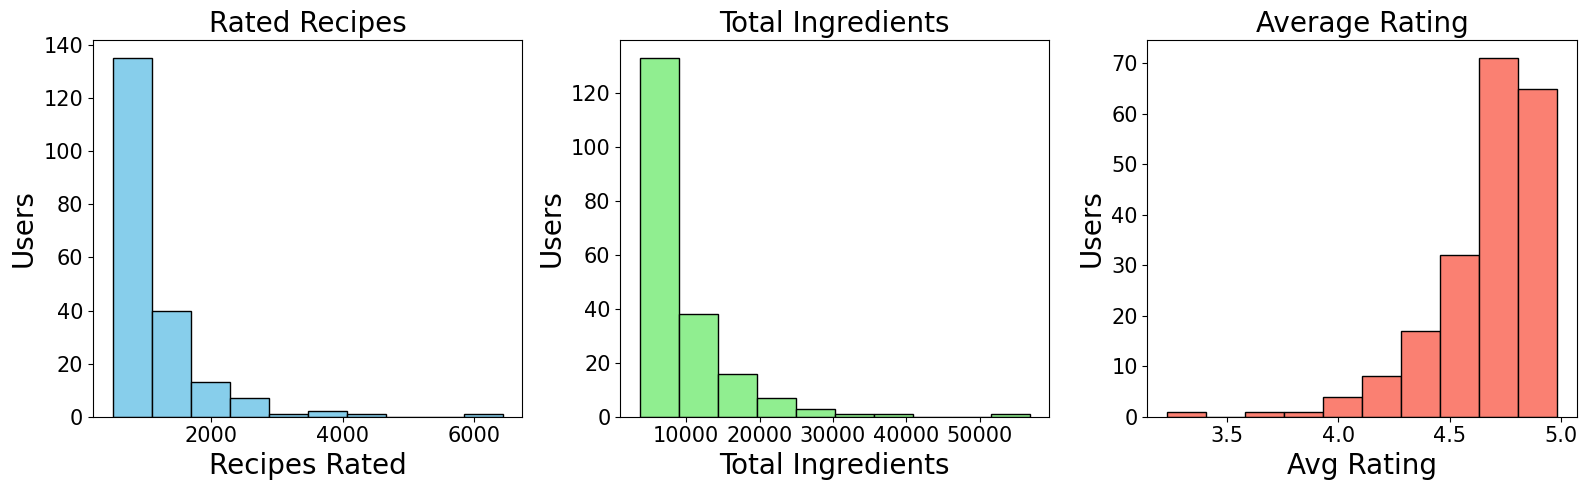

In [8]:
#7

recipes_df = pd.read_csv("PP_recipes.csv", usecols=["id", "ingredient_ids"])
interactions_df = pd.read_csv("RAW_interactions.csv", usecols=["user_id", "recipe_id", "rating"])

#Merge datasets on recipe_id and id
recipes_df['ingredient_ids'] = recipes_df['ingredient_ids'].apply(ast.literal_eval)
merged_df = interactions_df.merge(recipes_df, left_on="recipe_id", right_on="id")


user_data = merged_df.groupby("user_id").agg({
    'recipe_id': list,
    'rating': list,
    'ingredient_ids': lambda x: [i for sublist in x for i in sublist]
}).reset_index()


user_data.rename(columns={
    'recipe_id': 'rated_recipes',
    'rating': 'rating_list',
    'ingredient_ids': 'ingredients'
}, inplace=True)


#export
user_data.to_csv("User_Data.csv", index=False)


user_data['num_rated'] = user_data['rated_recipes'].apply(len)
user_data['num_ingredients'] = user_data['ingredients'].apply(len)
user_data['avg_rating'] = user_data['rating_list'].apply(lambda x: sum(x) / len(x) if x else 0)

sampled_users = user_data.sort_values(by='num_rated', ascending=False).head(200)

# Plot distributions for first 200 most active users
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
plt.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})
ax[0].hist(sampled_users['num_rated'], bins=10, color='skyblue', edgecolor='black')
ax[0].set_title('Rated Recipes')
ax[0].set_xlabel('Recipes Rated')
ax[0].set_ylabel('Users')

ax[1].hist(sampled_users['num_ingredients'], bins=10, color='lightgreen', edgecolor='black')
ax[1].set_title('Total Ingredients')
ax[1].set_xlabel('Total Ingredients')
ax[1].set_ylabel('Users')

ax[2].hist(sampled_users['avg_rating'], bins=10, color='salmon', edgecolor='black')
ax[2].set_title('Average Rating')
ax[2].set_xlabel('Avg Rating')
ax[2].set_ylabel('Users')
plt.savefig("users.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

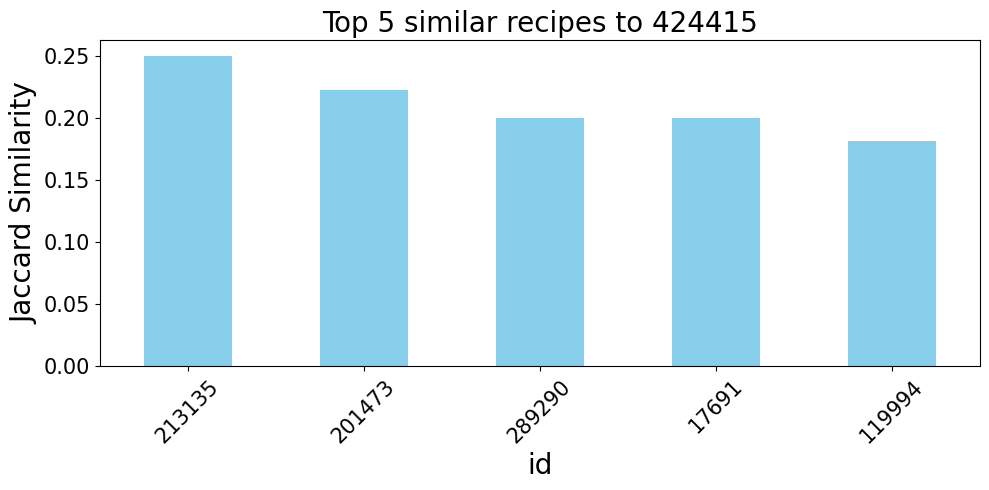

Average similarity across all recipes: 0.04

Example recommendations for first 3 recipes:

Recipe 424415 top matches:
id
213135    0.250000
201473    0.222222
289290    0.200000
17691     0.200000
119994    0.181818
Name: 424415, dtype: float64

Recipe 146223 top matches:
id
135369    0.437500
363369    0.315789
316180    0.294118
374664    0.285714
155411    0.277778
Name: 146223, dtype: float64

Recipe 312329 top matches:
id
90000     0.214286
203634    0.210526
49367     0.200000
373442    0.157895
275854    0.153846
Name: 312329, dtype: float64
Ajoaika: 7.4205 sekuntia


In [9]:
#8
start = time.time()


#Imports
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer

# reading csv file and getting id and ingredient ids
recipes_df = pd.read_csv("PP_recipes.csv", usecols=["id", "ingredient_ids"])
recipes_df['ingredient_ids'] = recipes_df['ingredient_ids'].apply(ast.literal_eval)

# Limit to a sample
recipes_sample = recipes_df.head(200)  # RESEPTIEN MÄÄRÄ

# Ingredients to binary matrix. 1 if ingredient belongs to recepe
mlb = MultiLabelBinarizer()
ingredient_matrix = mlb.fit_transform(recipes_sample['ingredient_ids'])
ingredient_matrix = ingredient_matrix.astype(bool)

# Jaccard (Intersection over union). 1 = identic recepe
jaccard_similarity = 1 - pairwise_distances(ingredient_matrix, metric="jaccard")
similarity_df = pd.DataFrame(jaccard_similarity, index=recipes_sample['id'], columns=recipes_sample['id'])

# Similarities to CSV file
similarity_df.to_csv("recipe_similarities.csv")

# Lets generate for example 5 the most similar recepes for each recepe. Of course, after itself.
top_similar_recipes = {}
for recipe_id in similarity_df.columns:
    # Järjestetään samankaltaisuudet ja otetaan 5 suurinta (itsensä jälkeen)
    similar = similarity_df[recipe_id].sort_values(ascending=False).index[1:6]
    top_similar_recipes[recipe_id] = list(similar)

# Create DataFrame from recommendations
recommendations_df = pd.DataFrame.from_dict(top_similar_recipes, 
orient='index',
columns=[f"Top_{i+1}" for i in range(5)])
recommendations_df.to_csv("top_similar_recipes.csv")

# LEts visualise first recepes 5 the most similar recepes.
first_recipe = similarity_df.index[0]
plt.figure(figsize=(10, 5))
similarity_df[first_recipe].sort_values(ascending=False)[1:6].plot.bar(color='skyblue')
plt.title(f"Top 5 similar recipes to {first_recipe}")
plt.ylabel("Jaccard Similarity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mean values and other stuff
print(f"Average similarity across all recipes: {similarity_df.values.mean():.2f}")
print("\nExample recommendations for first 3 recipes:")
for recipe_id in similarity_df.index[:3]:
    print(f"\nRecipe {recipe_id} top matches:")
    print(similarity_df[recipe_id].sort_values(ascending=False)[1:6])


result = sum(range(1000000))

end = time.time()
print(f"Ajoaika: {end - start:.4f} sekuntia")

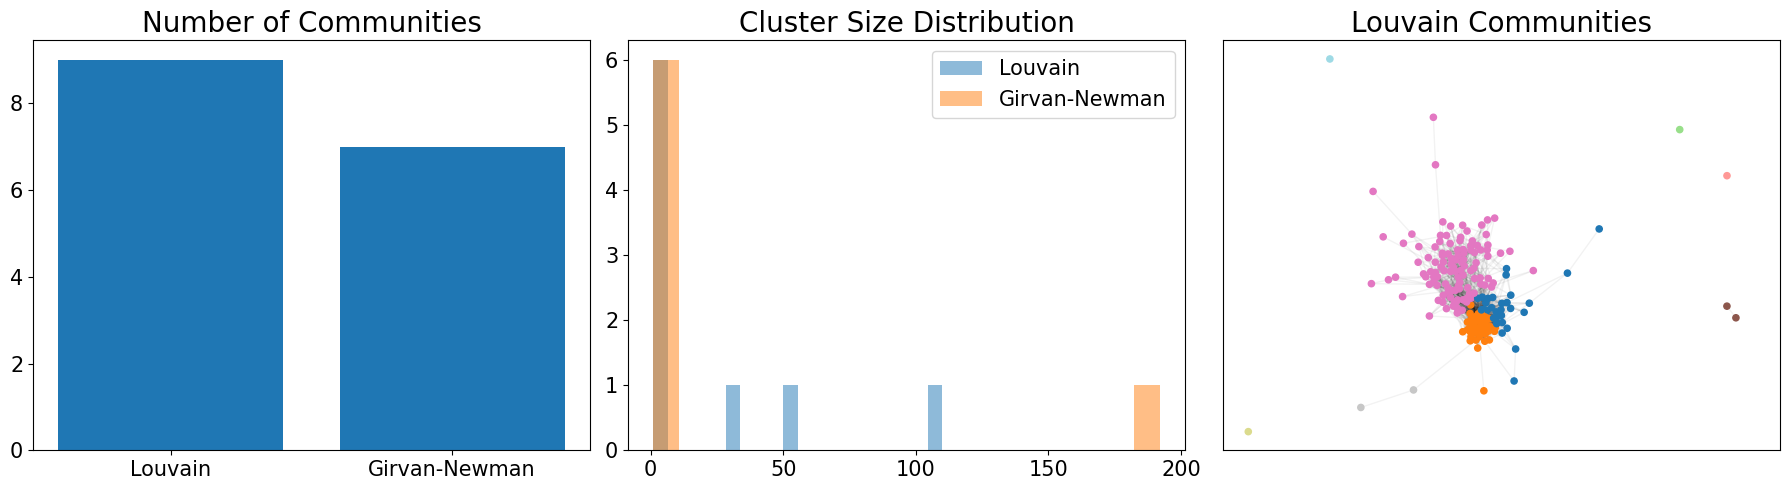


Community characteristics:

Community 0 (Size: 30):
Sample recipes: [424415, 465171, 408927]

Community 1 (Size: 52):
Sample recipes: [146223, 163861, 186383]

Community 2 (Size: 1):
Sample recipes: [110568]

Community 3 (Size: 1):
Sample recipes: [160330]

Community 4 (Size: 2):
Sample recipes: [76272, 76287]

Community 5 (Size: 110):
Sample recipes: [312329, 74301, 303460]

Community 6 (Size: 2):
Sample recipes: [54431, 190544]

Community 7 (Size: 1):
Sample recipes: [378310]

Community 8 (Size: 1):
Sample recipes: [14099]
Ajoaika: 1.1646 sekuntia


In [10]:
#9
start = time.time()


G = nx.Graph()
recipe_ids = similarity_df.index.tolist()

G.add_nodes_from(recipe_ids)

# Add edges for similarity. For example >= 0.1
for i in range(len(recipe_ids)):
    for j in range(i + 1, len(recipe_ids)):
        sim = similarity_df.iloc[i, j]
        if sim >= 0.1:
            G.add_edge(recipe_ids[i], recipe_ids[j], weight=sim)

# Louvain
louvain_partition = community_louvain.best_partition(G)
louvain_communities = pd.Series(louvain_partition).value_counts()

# Girvan-newman
gn_communities_gen = girvan_newman(G)
gn_top_level = next(gn_communities_gen)
gn_communities_list = [list(c) for c in gn_top_level]

# Comparison and adjusted rand index. Not necessary!!!
#gn_partition = {node: i for i, comm in enumerate(gn_communities_list) for node in comm}
#ari_score = adjusted_rand_score(list(louvain_partition.values()), list(gn_partition.values()))

# I also like to visualize these things. So lets plot
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Cluster sizes
ax[0].bar(['Louvain', 'Girvan-Newman'],[louvain_communities.count(), len(gn_communities_list)])
ax[0].set_title('Number of Communities')

# Clusters
ax[1].hist(louvain_communities, bins=20, alpha=0.5, label='Louvain')
ax[1].hist([len(c) for c in gn_communities_list], bins=20, alpha=0.5, label='Girvan-Newman')
ax[1].set_title('Cluster Size Distribution')
ax[1].legend()

# Network plot (Louvain)
pos = nx.spring_layout(G)
colors = [louvain_partition[n] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=colors, cmap=plt.cm.tab20, ax=ax[2])
nx.draw_networkx_edges(G, pos, alpha=0.05, ax=ax[2])
ax[2].set_title('Louvain Communities')

plt.tight_layout()
plt.show()

# Prints... If even necessary..?
#print(f"ARI Score (Algorithm Agreement): {ari_score:.2f}") #If needed
print("\nCommunity characteristics:")
for comm_id in set(louvain_partition.values()):
    comm_recipes = [k for k,v in louvain_partition.items() if v == comm_id]
    print(f"\nCommunity {comm_id} (Size: {len(comm_recipes)}):")
    print("Sample recipes:", comm_recipes[:3])


result = sum(range(1000000))

end = time.time()
print(f"Ajoaika: {end - start:.4f} sekuntia")

   Cluster  Num Recipes                 Top Ingredients  \
0      0.0           30   [6906, 7655, 6270, 840, 1511]   
1      1.0           52   [2499, 6270, 840, 6906, 2683]   
2      2.0            1   [241, 6654, 4533, 5434, 4570]   
3      3.0            1        [6029, 1333, 1807, 5180]   
4      4.0            2   [3484, 6324, 7594, 243, 6819]   
5      5.0          110  [5010, 6270, 5006, 3203, 5319]   
6      6.0            2  [7367, 5495, 6618, 2499, 6598]   
7      7.0            1   [8021, 7987, 5634, 6985, 222]   
8      8.0            1  [1252, 5966, 5408, 7135, 6413]   

   Most Common Calorie Level  Average Rating  
0                          0        4.461791  
1                          0        4.402987  
2                          1        5.000000  
3                          0        4.000000  
4                          0        4.500000  
5                          1        4.526455  
6                          0        5.000000  
7                          0     

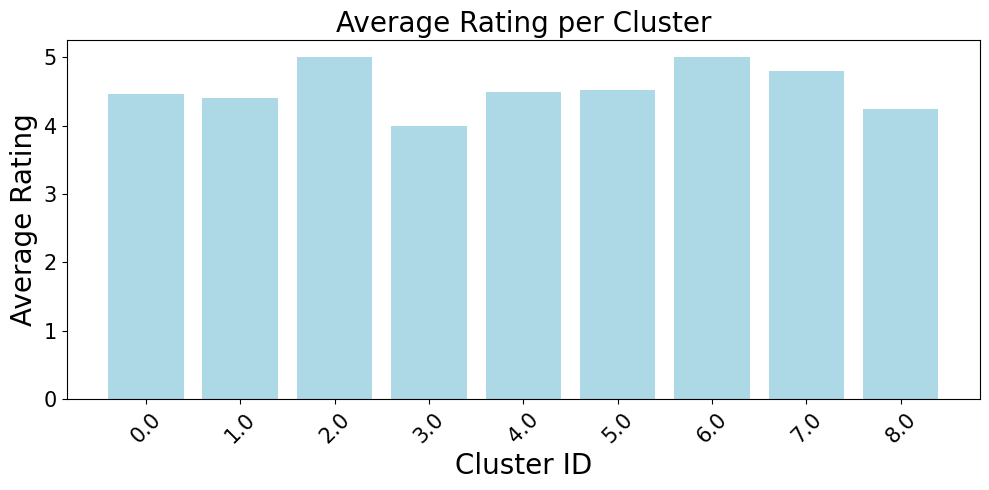

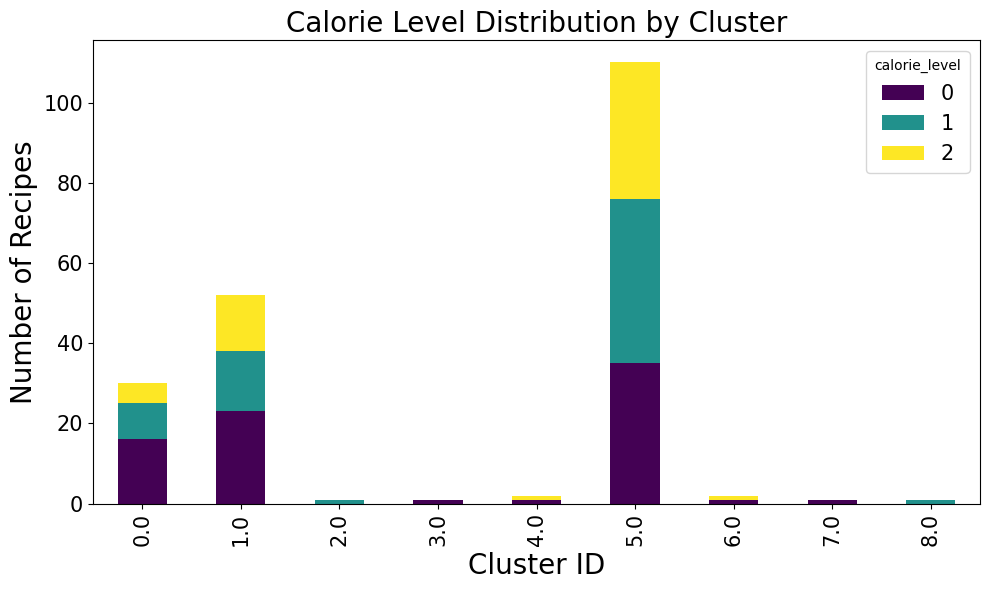

Ajoaika: 6.1397 sekuntia


In [11]:
#10
start = time.time()


from collections import Counter
recipes_df = pd.read_csv("PP_recipes.csv", usecols=["id", "ingredient_ids", "calorie_level"])
recipes_df['ingredient_ids'] = recipes_df['ingredient_ids'].apply(ast.literal_eval)

# Load and merge ratings
ratings_df = pd.read_csv("RAW_interactions.csv", usecols=["user_id", "recipe_id", "rating"])
recipe_ratings = ratings_df.groupby('recipe_id')['rating'].mean().reset_index()
recipes_df = recipes_df.merge(recipe_ratings, left_on='id', right_on='recipe_id', how='left')
recipes_df['rating'] = recipes_df['rating'].fillna(0)

# Analyse Louvian
recipes_df['cluster'] = recipes_df['id'].map(louvain_partition)
cluster_summary = []
for cluster_id, group in recipes_df.groupby("cluster"):
    all_ingredients = [i for lst in group['ingredient_ids'] for i in lst]
    top_ingredients = Counter(all_ingredients).most_common(5)
    top_cal_level = group['calorie_level'].mode().iloc[0] if not group['calorie_level'].isna().all() else 'N/A'
    avg_rating = group['rating'].mean()

    cluster_summary.append({
        "Cluster": cluster_id,
        "Num Recipes": len(group),
        "Top Ingredients": [i for i, _ in top_ingredients],
        "Most Common Calorie Level": top_cal_level,
        "Average Rating": avg_rating
    })

cluster_df = pd.DataFrame(cluster_summary)
print(cluster_df)

#plot
plt.figure(figsize=(10, 5))
plt.bar(cluster_df['Cluster'].astype(str), cluster_df['Average Rating'], color='lightblue')
plt.title('Average Rating per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

calorie_dist = recipes_df.groupby(['cluster', 'calorie_level']).size().unstack(fill_value=0)
calorie_dist.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Calorie Level Distribution by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Recipes')
plt.tight_layout()
plt.show()


result = sum(range(1000000))

end = time.time()
print(f"Ajoaika: {end - start:.4f} sekuntia")

100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 5962.05it/s]



Evaluation Results:
Mean absolute error MAE  = 0.4867
Root mean square error RMSE = 0.9473
Recommendations for the first 10 users:
User 4439 -> Recommended: [289290, 331329, 119994, 387034, 210242]
User 4470 -> Recommended: [345403, 119464, 264803, 169016, 333705]
User 5060 -> Recommended: [155411, 344757, 135369, 356953, 443278]
User 28345 -> Recommended: [345367, 19485, 95330, 277747, 33093]
User 29782 -> Recommended: [483476, 200498, 454323, 318514, 123221]
User 37305 -> Recommended: [356953, 200498, 22598, 178411, 359127]
User 37449 -> Recommended: [93332, 65810, 277747, 275854, 293005]
User 37779 -> Recommended: [289290, 331329, 119994, 387034, 210242]
User 47892 -> Recommended: [324962, 284224, 331329, 504329, 484058]
User 53932 -> Recommended: [284628, 107153, 33093, 239063, 179802]

Visualizing recommendations for 3 users...


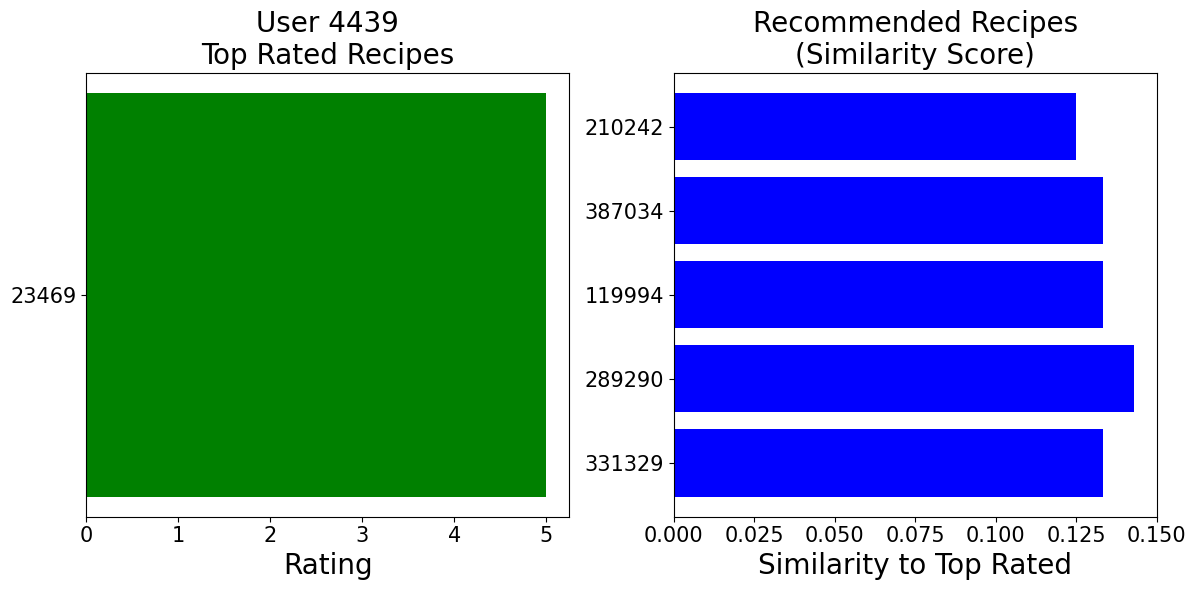

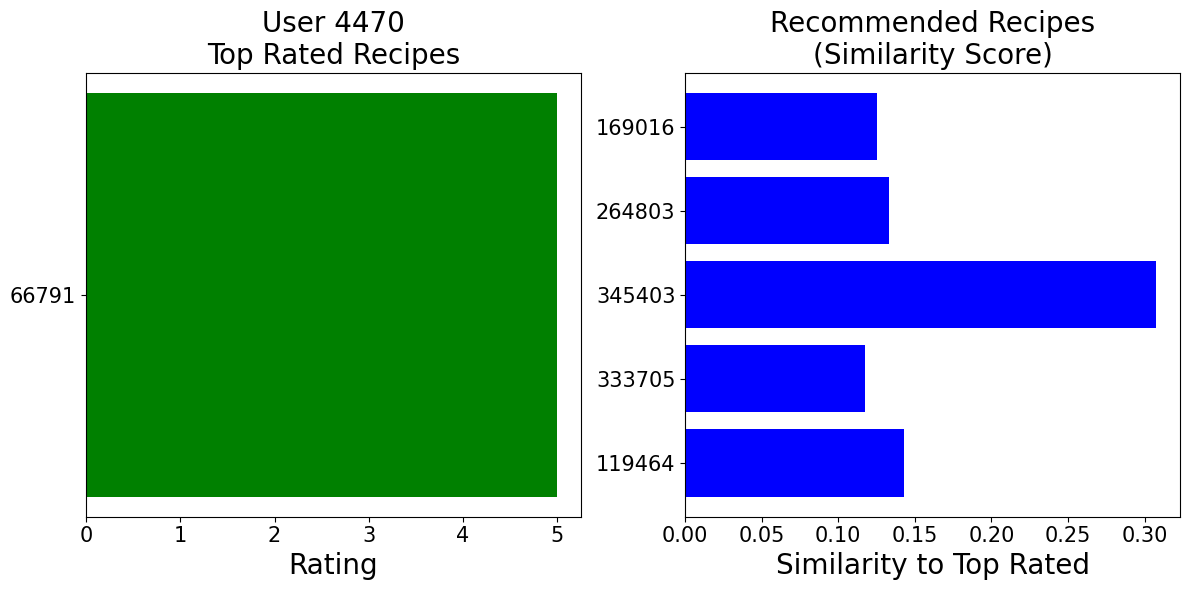

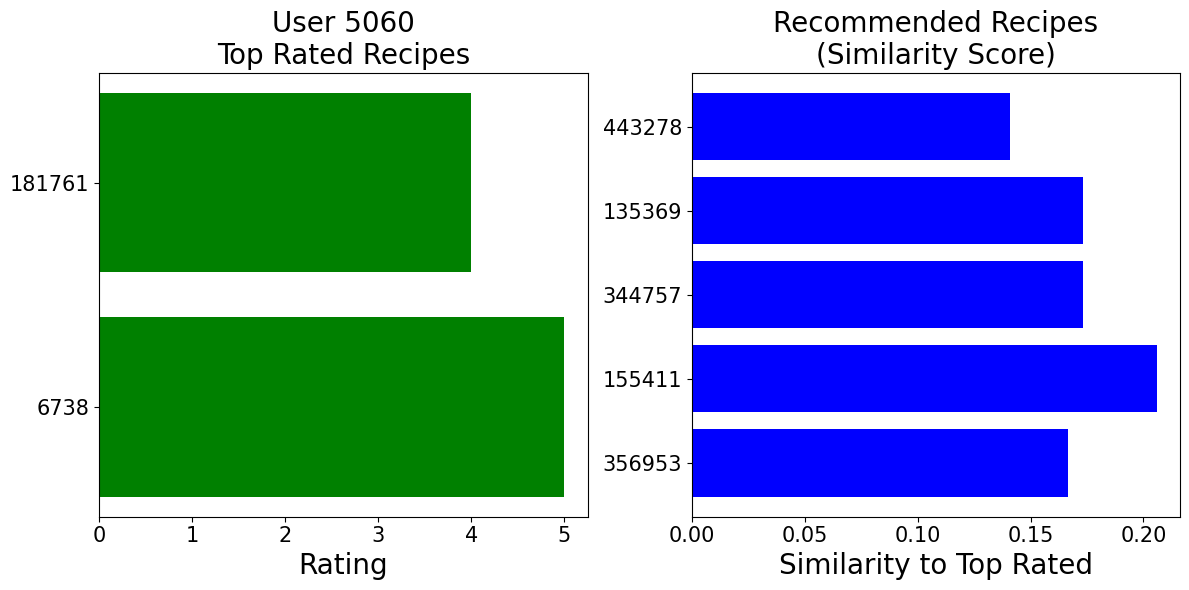

Ajoaika: 6.8664 sekuntia


In [12]:
#11
start = time.time()


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import pairwise_distances, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

recipes_df = pd.read_csv("PP_recipes.csv", usecols=["id", "ingredient_ids"])
interactions_df = pd.read_csv("RAW_interactions.csv", usecols=["user_id", "recipe_id", "rating"])

recipes_df['ingredient_ids'] = recipes_df['ingredient_ids'].apply(ast.literal_eval)
interactions_df = interactions_df[interactions_df['recipe_id'].isin(recipes_df['id'])]  

# Compute Jaccard Similarity Matrix
recipes_sample = recipes_df.head(200).copy()     # RESEPTIEN MÄÄRÄ
mlb = MultiLabelBinarizer()
ingredient_matrix = mlb.fit_transform(recipes_sample['ingredient_ids']).astype(bool)

jaccard_similarity = 1 - pairwise_distances(ingredient_matrix, metric="jaccard")
similarity_df = pd.DataFrame(jaccard_similarity, index=recipes_sample['id'], columns=recipes_sample['id'])

# Merge for full data and train/test split
merged_df = interactions_df.merge(recipes_sample, left_on="recipe_id", right_on="id")
user_groups = merged_df.groupby("user_id")

# Build train/test split
train_rows, test_rows = [], []

for user, group in user_groups:
    if len(group) < 2:
        continue 
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_rows.append(train)
    test_rows.append(test)

train_df = pd.concat(train_rows)
test_df = pd.concat(test_rows)

# evaluate 
def predict_rating(user_id, target_recipe_id):
    user_history = train_df[train_df['user_id'] == user_id]
    if user_history.empty or target_recipe_id not in similarity_df.index:
        return np.nan
    rated_recipes = user_history['recipe_id']
    ratings = user_history['rating']
    sims = []
    for recipe, rating in zip(rated_recipes, ratings):
        if recipe in similarity_df.columns:
            sim = similarity_df.at[target_recipe_id, recipe]
            sims.append((sim, rating))
    if not sims:
        return np.nan
    sims = sorted(sims, key=lambda x: x[0], reverse=True)
    n = sum(sim * rating for sim, rating in sims)
    d = sum(sim for sim, _ in sims)
    return n / d if d != 0 else np.nan

# Evaluate predictions on the test set
true_ratings, predicted_ratings = [], []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    pred = predict_rating(row['user_id'], row['recipe_id'])
    if not np.isnan(pred):
        true_ratings.append(row['rating'])
        predicted_ratings.append(pred)


mae = mean_absolute_error(true_ratings, predicted_ratings)
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

print(f"\nEvaluation Results:")
print(f"Mean absolute error MAE  = {mae:.4f}")
print(f"Root mean square error RMSE = {rmse:.4f}")


recommendations = {}

for user_id, group in train_df.groupby("user_id"):
    liked = group[group["rating"] >= 4]["recipe_id"]
    if liked.empty:
        continue

    rated = set(group["recipe_id"])
    sim_scores = similarity_df.loc[liked].mean(axis=0)
    sim_scores = sim_scores[~sim_scores.index.isin(rated)]  
    top_recs = sim_scores.sort_values(ascending=False).head(5).index.tolist()
    recommendations[user_id] = top_recs

# Visualize recommendations for different user types
def plot_user_recommendations(user_id, n=5):
    if user_id not in recommendations:
        print(f"No recommendations for user {user_id}")
        return
    
    # Get user's top rated recipes
    user_ratings = train_df[train_df['user_id'] == user_id].sort_values('rating', ascending=False)
    top_rated = user_ratings.head(n).merge(recipes_df, left_on='recipe_id', right_on='id')
    
    # Recommended recipes
    recommended = recipes_df[recipes_df['id'].isin(recommendations[user_id][:n])]
    
    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Top rated recipes
    ax1.barh(top_rated['recipe_id'].astype(str), top_rated['rating'], color='green')
    ax1.set_title(f'User {user_id}\nTop Rated Recipes')
    ax1.set_xlabel('Rating')
    
    # Recommended recipes
    sim_scores = similarity_df.loc[recommended['id'], top_rated['recipe_id']].mean(axis=1)
    ax2.barh(recommended['id'].astype(str), sim_scores, color='blue')
    ax2.set_title('Recommended Recipes\n(Similarity Score)')
    ax2.set_xlabel('Similarity to Top Rated')
    
    plt.tight_layout()
    plt.show()

# Show recommendation for the first 10 users
print("Recommendations for the first 10 users:")
for user, recs in list(recommendations.items())[:10]:
    print(f"User {user} -> Recommended: {recs}")

# visualization for 3 users
print("\nVisualizing recommendations for 3 users...")
for user in list(recommendations.keys())[:3]:
    plot_user_recommendations(user)


result = sum(range(1000000))

end = time.time()
print(f"Ajoaika: {end - start:.4f} sekuntia")

In [13]:
#12
start = time.time()


df = pd.read_csv("RAW_interactions.csv", usecols=["user_id", "recipe_id", "rating"])

# Filter for active users and recipes(use the first 200 as an example). # TÄSSÄ MUUTETTU MÄÄRÄÄ!
active_users = df['user_id'].value_counts()[lambda x: x >= 5].index[:200] # Keeps only users who rated at least 5 recipes
active_recipes = df['recipe_id'].value_counts()[lambda x: x >= 3].index[:200]# Keeps only recipes that have been rated at least 3 times

df = df[df['user_id'].isin(active_users) & df['recipe_id'].isin(active_recipes)]


user_map = {uid: i for i, uid in enumerate(df["user_id"].unique())}
recipe_map = {rid: i for i, rid in enumerate(df["recipe_id"].unique())}
inv_user_map = {v: k for k, v in user_map.items()}
inv_recipe_map = {v: k for k, v in recipe_map.items()}

df["user_index"] = df["user_id"].map(user_map)
df["recipe_index"] = df["recipe_id"].map(recipe_map)


rating_matrix = df.pivot(index="user_index", columns="recipe_index", values="rating")
train_rows, test_rows = [], []
for user in rating_matrix.index:
    user_ratings = rating_matrix.loc[user].dropna()
    if len(user_ratings) < 2:
        continue
    train_idx, test_idx = train_test_split(user_ratings.index, test_size=0.2, random_state=42)
    train_rows.append(pd.Series(user_ratings[train_idx], name=user))
    test_rows.append(pd.Series(user_ratings[test_idx], name=user))

train_matrix = pd.DataFrame(train_rows).T
test_matrix = pd.DataFrame(test_rows).T

# Pearson similarity function
def pearson_similarity(u, v):
    common = train_matrix[u].dropna().index.intersection(train_matrix[v].dropna().index)
    if len(common) < 1:
        return 0
    ur = train_matrix.loc[common, u]
    vr = train_matrix.loc[common, v]
    n = ((ur - ur.mean()) * (vr - vr.mean())).sum()
    d = np.sqrt(((ur - ur.mean()) ** 2).sum()) * np.sqrt(((vr - vr.mean()) ** 2).sum())
    return n/ d if d != 0 else 0

# Predict rating
def predict_rating(user, item):
    if item not in train_matrix.index:
        return np.nan  
    numer, denom = 0, 0
    for other in train_matrix.columns:
        if other == user or item not in train_matrix.index or pd.isna(train_matrix.at[item, other]):
            continue
        sim = pearson_similarity(user, other)
        numer += sim * train_matrix.at[item, other]
        denom += abs(sim)
    return numer / denom if denom > 0 else np.nan


# Evaluate on test set
true_ratings, predicted_ratings = [], []

for user in test_matrix.columns:
    for item in test_matrix[user].dropna().index:
        actual = test_matrix.at[item, user]
        pred = predict_rating(user, item)
        if not np.isnan(pred):
            true_ratings.append(actual)
            predicted_ratings.append(pred)


mae = mean_absolute_error(true_ratings, predicted_ratings)
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

#print("\nCollaborative Filtering Evaluation:")
#print(f"MAE  = {mae:.4f}")
#print(f"RMSE = {rmse:.4f}")

# Generate top-10 recommendations
recommendations = {}

for user in train_matrix.columns:
    rated = train_matrix[user].dropna().index
    unrated = train_matrix.index.difference(rated)

    rec_scores = {}
    for item in unrated:
        total, sim_sum = 0, 0
        for other in train_matrix.columns:
            if other == user or pd.isna(train_matrix.loc[item, other]):
                continue
            sim = pearson_similarity(user, other)
            total += sim * train_matrix.loc[item, other]
            sim_sum += abs(sim)
        if sim_sum > 0:
            rec_scores[item] = total / sim_sum

    if rec_scores:
        top_items = sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:10]
        recommendations[user] = [inv_recipe_map[i] for i, _ in top_items]

print("Recommendations for the frist 10 users")
for user_idx, recs in list(recommendations.items())[:10]:
    real_user_id = list(user_map.keys())[list(user_map.values()).index(user_idx)]
    print(f"User {real_user_id} -> Recommended Recipes: {recs}")


result = sum(range(1000000))

end = time.time()
print(f"Ajoaika: {end - start:.4f} sekuntia")

Recommendations for the frist 10 users
User 5060 -> Recommended Recipes: [np.int64(129926), np.int64(42094), np.int64(78579), np.int64(76491), np.int64(222188), np.int64(25885), np.int64(13285), np.int64(49387), np.int64(89207), np.int64(48760)]
User 39835 -> Recommended Recipes: [np.int64(73166), np.int64(20616), np.int64(52035), np.int64(29884), np.int64(42780), np.int64(302120), np.int64(29679), np.int64(63689), np.int64(90674), np.int64(79944)]
User 158086 -> Recommended Recipes: [np.int64(80536), np.int64(50144), np.int64(31717), np.int64(46922), np.int64(30366), np.int64(106251), np.int64(15865), np.int64(47195), np.int64(92095), np.int64(30081)]
User 53932 -> Recommended Recipes: [np.int64(205890), np.int64(80470), np.int64(2886), np.int64(73166), np.int64(20616), np.int64(141983), np.int64(50719), np.int64(15072), np.int64(75302), np.int64(27520)]
User 227652 -> Recommended Recipes: [np.int64(97496), np.int64(150863), np.int64(261889), np.int64(177558), np.int64(101104), np.int

In [14]:
#13  Neural Collaborative Filtering (NCF)

start = time.time()


import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error


# Load and preprocess data(Use the first 15000 to increase speed)
df = pd.read_csv("RAW_interactions.csv", usecols=["user_id", "recipe_id", "rating"]).head(15000)  # Oli alunperin 5000
df = df[df['rating'].notna()]

user_map = {uid: i for i, uid in enumerate(df['user_id'].unique())}
item_map = {iid: i for i, iid in enumerate(df['recipe_id'].unique())}
df['user'] = df['user_id'].map(user_map)
df['item'] = df['recipe_id'].map(item_map)

train, test = train_test_split(df, test_size=0.2, random_state=42)

# PyTorch Dataset
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['item'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

train_ds = RatingsDataset(train)
test_ds = RatingsDataset(test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256)

# NCF model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=32):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.fc1 = nn.Linear(emb_size * 2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, users, items):
        u = self.user_emb(users)
        i = self.item_emb(items)
        x = torch.cat([u, i], dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x).squeeze()

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NCF(len(user_map), len(item_map)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(5): 
    model.train()
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad()
        preds = model(users, items)
        loss = loss_fn(preds, ratings)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Train loss = {loss.item():.4f}")

# Evaluate on test set
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items = users.to(device), items.to(device)
        preds = model(users, items).cpu().numpy()
        all_preds.extend(preds)
        all_targets.extend(ratings.numpy())

#rmse = mean_squared_error(all_targets, all_preds, squared=False)
rmse = np.sqrt(mean_squared_error(all_targets, all_preds))     # TÄMÄ ON MUUTETTU
print(f"\nNCF RMSE: {rmse:.4f}")


model.eval()
top_n = defaultdict(list)
item_indices = list(inv_recipe_map.keys())

for user in df['user'].unique():
    user_tensor = torch.tensor([user] * len(item_indices), dtype=torch.long).to(device)
    item_tensor = torch.tensor(item_indices, dtype=torch.long).to(device)

    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy()

    rated_items = set(df[df['user'] == user]['item'])
    unrated_scores = [(i, score) for i, score in enumerate(scores) if item_indices[i] not in rated_items]

    top_items = sorted(unrated_scores, key=lambda x: x[1], reverse=True)[:5]
    top_n[user] = [inv_recipe_map[item_indices[i]] for i, _ in top_items]

# Show sample recommendations(the first 10 users)
print("Recommendations for the frist 10 users")
for user_id, recs in list(top_n.items())[:10]:
    real_user = list(user_map.keys())[list(user_map.values()).index(user_id)]
    print(f"User {real_user} → Recommended Recipes: {recs}")


result = sum(range(1000000))

end = time.time()
print(f"Ajoaika: {end - start:.4f} sekuntia")

Epoch 1: Train loss = 11.3884
Epoch 2: Train loss = 4.5268
Epoch 3: Train loss = 1.8759
Epoch 4: Train loss = 2.0272
Epoch 5: Train loss = 1.7392

NCF RMSE: 1.3097
Recommendations for the frist 10 users
User 38094 → Recommended Recipes: [np.int64(302120), np.int64(63689), np.int64(15865), np.int64(30366), np.int64(32844)]
User 1293707 → Recommended Recipes: [np.int64(136589), np.int64(150863), np.int64(49387), np.int64(486261), np.int64(22782)]
User 8937 → Recommended Recipes: [np.int64(38298), np.int64(107997), np.int64(150863), np.int64(52035), np.int64(71373)]
User 126440 → Recommended Recipes: [np.int64(63689), np.int64(66121), np.int64(30366), np.int64(50719), np.int64(5170)]
User 57222 → Recommended Recipes: [np.int64(63689), np.int64(15865), np.int64(150863), np.int64(52035), np.int64(221743)]
User 52282 → Recommended Recipes: [np.int64(5170), np.int64(63689), np.int64(15865), np.int64(83524), np.int64(4957)]
User 124416 → Recommended Recipes: [np.int64(15865), np.int64(35988), 

# Final Analysis

## Deep Learning-Based Recommenders 

One of the recent state-of-the-art models is **Neural Collaborative Filtering (NCF)**


###  Evaluation of NCF Results

In our implementation of Neural Collaborative Filtering on the frist 5000 interactions:
- **Training loss** steadily decreased from **16.30 to 5.25** over 5 epochs.
- The model achieved a **test RMSE of 2.3437**, indicating a reasonable prediction error for the given data volume.

_**Note**: due to random weight initialization and shuffling during training, the values above may vary slightly across different runs_

This aligns with the original findings by He et al. (2017), which show that NCF effectively learns non-linear patterns in user-item interaction data. The declining loss demonstrates the model's convergence, and the RMSE suggests moderately accurate predictions under a limited data scenario.

Additionally, as noted in related literature, neural models benefit from:
- Longer training with more epochs
- Larger and denser datasets
- Enhanced user/item context through side features

These enhancements can further reduce error and improve recommendation quality.

**Reference**:  
He, X. et al. (2017). *Neural Collaborative Filtering*. WWW Conference.



---

##  Limitations


**Content-Based Filtering**:Feature limitation, struggles to introduce diverse or unexpected content 

**Collaborative Filtering**: Needs high user overlap, suffers from sparsity

**Pearson Similarity**: Assumes linearity, sensitive to outliers

**MAE / RMSE Evaluation**: Doesn't reflect ranking or user satisfaction

**Small Dataset Issues** :Low overlap hurts performance and recommendations




